## Importing the necessary libraries

In [216]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from textblob import TextBlob
from sklearn.metrics import accuracy_score, confusion_matrix

## Reading in the cleaned corpus

In [238]:
# Loading and formatting dataframe
df = pd.read_csv("final_labelled.csv")
df["Date"] = pd.to_datetime(df["Date"])
df["Review"] = df["Comment"].apply(str)
df["Restaurant"] = df["Name"]
df['Stars'] = df["Star"]
reviews = df[['Restaurant', 'Review', 'Date', 'Label', 'Stars']]

## Getting a DataFrame of reviews by restaurants

In [240]:
# To get unique restaurant names
restaurant_names = []
for rest in reviews["Restaurant"]: # each restaurant name
    if rest not in restaurant_names: 
        restaurant_names.append(rest)

print(len(restaurant_names)) # number of restaurants

779


In [244]:
# To get restaurant name and respective reviews (separately including date)
reviewsByRestaurant = dict.fromkeys(restaurant_names, "")
for rest in restaurant_names: 
    filtered= []
    reviewsByRestaurant[rest] = [] # to contain a list of sentences for that restaurant    
    filtered = reviews[reviews['Restaurant'] == rest]
    for i in range(len(filtered)): 
        review_info = {} # to contain key value pairs of label: sentence, date: date
        review_info['Review'] = filtered.iloc[i]['Review']
        review_info['Date'] = pd.to_datetime(filtered.iloc[i]['Date'])
        review_info['Label'] = filtered.iloc[i]['Label']
        review_info['Stars'] = filtered.iloc[i]['Stars']
        reviewsByRestaurant[rest].append(review_info)

print(reviewsByRestaurant)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [245]:
# To get df of restaurant and labels with date
rows = []

for rest in restaurant_names:
    for review_info in reviewsByRestaurant[rest]:
        review_info['Restaurant'] = rest
        rows.append(review_info)

df = pd.DataFrame(rows)
df = df[['Restaurant', 'Review', 'Date', 'Label', 'Stars']]

df.head()

,Restaurant,Review,Date,Label,Stars
0,Fratini La Trattoria,This is one of my absolute favorite restaurant...,2013-03-14,5,5
1,Fratini La Trattoria,I like the relieve from having to decide what ...,2015-02-06,5,4
2,Fratini La Trattoria,It has been a while since I've had such a good...,2016-02-26,2,5
3,Fratini La Trattoria,Not to rub it in but the table next to yours h...,2014-01-18,3,4
4,Fratini La Trattoria,Overall a wonderful dining experience.,2015-02-06,1,4


In [246]:
# Checking datatype for each column
df.dtypes

Restaurant            object
Review                object
Date          datetime64[ns]
Label                  int64
Stars                  int64
dtype: object

In [247]:
# Viewing dataset
df.head()

,Restaurant,Review,Date,Label,Stars
0,Fratini La Trattoria,This is one of my absolute favorite restaurant...,2013-03-14,5,5
1,Fratini La Trattoria,I like the relieve from having to decide what ...,2015-02-06,5,4
2,Fratini La Trattoria,It has been a while since I've had such a good...,2016-02-26,2,5
3,Fratini La Trattoria,Not to rub it in but the table next to yours h...,2014-01-18,3,4
4,Fratini La Trattoria,Overall a wonderful dining experience.,2015-02-06,1,4


In [248]:
# Viewing specifications of dataset
df.shape

(75324, 5)

# Sentiment Analysis

In [249]:
from textblob import TextBlob
import numpy as np
import math
from sklearn.metrics import accuracy_score

In [250]:
# Sentiment polarity analysis for each review
df["sentiment_polarity"] = df.apply (lambda row: TextBlob(row[1]).sentiment.polarity, axis=1)

In [251]:
# Viewing dataframe with sentiment scores
df.head()

,Restaurant,Review,Date,Label,Stars,sentiment_polarity
0,Fratini La Trattoria,This is one of my absolute favorite restaurant...,2013-03-14,5,5,0.490625
1,Fratini La Trattoria,I like the relieve from having to decide what ...,2015-02-06,5,4,0.000000
2,Fratini La Trattoria,It has been a while since I've had such a good...,2016-02-26,2,5,0.300000
3,Fratini La Trattoria,Not to rub it in but the table next to yours h...,2014-01-18,3,4,0.191667
4,Fratini La Trattoria,Overall a wonderful dining experience.,2015-02-06,1,4,0.500000


In [252]:
# adjusting sentiment scores to [0 - 1] range
def adj_sentiment(sentiment):
    return ((sentiment + 1)/2)

In [253]:
# adjusting sentiment
df["adjusted_sentiment"] = df.apply (lambda row: adj_sentiment(row[5]), axis=1)

In [254]:
# Viewing dataframe with sentiment scores
df.head()

,Restaurant,Review,Date,Label,Stars,sentiment_polarity,adjusted_sentiment
0,Fratini La Trattoria,This is one of my absolute favorite restaurant...,2013-03-14,5,5,0.490625,0.745313
1,Fratini La Trattoria,I like the relieve from having to decide what ...,2015-02-06,5,4,0.000000,0.500000
2,Fratini La Trattoria,It has been a while since I've had such a good...,2016-02-26,2,5,0.300000,0.650000
3,Fratini La Trattoria,Not to rub it in but the table next to yours h...,2014-01-18,3,4,0.191667,0.595833
4,Fratini La Trattoria,Overall a wonderful dining experience.,2015-02-06,1,4,0.500000,0.750000


# Creating Date weights

In [255]:
# Ensuring df shape
df.shape

(75324, 7)

In [256]:
# Creating rank for each row according to restaurant, label and then date
df = df.sort_values(['Restaurant', 'Label', 'Date'], ascending = (True, True, False))
tmp = df.groupby(['Restaurant', 'Label']).size()
rank_range = tmp.map(range)
rank =[(item +1) for sublist in rank_range for item in sublist]
len(rank)

75324

In [257]:
# Creating reciprocal ranks weights for each input
df["weights"] = [1/x for x in rank]

In [258]:
df.head()

,Restaurant,Review,Date,Label,Stars,sentiment_polarity,adjusted_sentiment,weights
14278,10 at Claymore,"Unlike lunch, dinner is sold out at 10 at Clay...",2017-04-18,1,4,0.00000,0.500000,1.000000
14402,10 at Claymore,Would have preferred a pasta station.The price...,2017-03-25,1,4,0.00000,0.500000,0.500000
14336,10 at Claymore,Pretty good deal if you like oysters and other...,2017-01-30,1,4,0.27500,0.637500,0.333333
14381,10 at Claymore,There's an ongoing $98++ for two pax CNY promo...,2017-01-30,1,4,0.00000,0.500000,0.250000
14320,10 at Claymore,"The sushi corner was acceptable, with the usua...",2014-10-02,1,4,0.08125,0.540625,0.200000


# Star Prediction for each Label

In [259]:
# Creating recency weighted average grouped by 
def grouped_weighted_avg(values, weights, by):
    return (values * weights).groupby(by).sum() / weights.groupby(by).sum()

In [260]:
# Removing label 5 since it is not a preassigned class
clean_data = df[df.Label != 5]

In [261]:
# Calculating exponentially rencency weighted average of sentiment for eah label
label_sentiment = grouped_weighted_avg(clean_data["adjusted_sentiment"], clean_data["weights"], (clean_data["Restaurant"], clean_data["Label"]))

c:\users\seagate pc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  This is separate from the ipykernel package so we can avoid doing imports until


In [262]:
# Adjusting sentiment to fit [1,5]
adj_label_sentiment = label_sentiment.apply((lambda x: math.ceil(x*5)))

In [263]:
# Viewing the predicted stars for each predetermined aspect
adj_label_sentiment.head()

Restaurant        Label
10 at Claymore    1        3
                  2        4
                  3        4
                  4        4
126 Eating House  1        4
dtype: int64

In [264]:
# Viewing the shape of the dataframe
adj_label_sentiment.shape

(2800,)

In [265]:
pred_label = []
for x in adj_label_sentiment:
    pred_label.append(x)

In [266]:
# Calculating exponentially rencency weighted average of stars for labels
label_star = grouped_weighted_avg(clean_data["Stars"], clean_data["weights"], (clean_data["Restaurant"], clean_data["Label"]))

c:\users\seagate pc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  This is separate from the ipykernel package so we can avoid doing imports until


In [267]:
adj_label_star = label_star.apply((lambda x: math.ceil(x)))

In [268]:
adj_label_star.head()

Restaurant        Label
10 at Claymore    1        5
                  2        5
                  3        5
                  4        5
126 Eating House  1        4
dtype: int64

In [269]:
adj_label_star.shape

(2800,)

In [270]:
label_truth = []
for x in adj_label_star:
    label_truth.append(x)

In [271]:
# Accuracy of sentiment predicted stars and the average stars for each label
accuracy_score(label_truth, pred_label)

0.22392857142857142

In [272]:
taste_truth = adj_label_star[adj_label_star.index.get_level_values("Label").isin(["2"])]
taste_pred = adj_label_sentiment[adj_label_sentiment.index.get_level_values("Label").isin(["2"])]
print("TASTE CONFUSION MATRIX:")
print(confusion_matrix(taste_truth, taste_pred))
print()
print("TASTE ACCURACY:")
print(accuracy_score(taste_truth, taste_pred))

TASTE CONFUSION MATRIX:
[[  0   1   1   0   1   0]
 [  1   0   2   1   0   0]
 [  0   0  13   2   0   0]
 [  0   3 104 153   8   0]
 [  1   3 131 314  22   0]
 [  0   0   1   1   0   0]]

TASTE ACCURACY:
0.24639580602883354


In [273]:
value_truth = adj_label_star[adj_label_sentiment.index.get_level_values("Label").isin(["1"])]
value_pred = adj_label_sentiment[adj_label_sentiment.index.get_level_values("Label").isin(["1"])]
print("VALUE CONFUSION MATRIX:")
print(confusion_matrix(value_truth, value_pred))
print()
print("VALUE ACCURACY:")
print(accuracy_score(value_truth, value_pred))

VALUE CONFUSION MATRIX:
[[  0   1   2   0   0   0]
 [  0   0   1   2   0   0]
 [  0   2  42   7   0   0]
 [  0   2 190  89   2   0]
 [  0   5 183 140   9   0]
 [  0   0   0   1   0   0]]

VALUE ACCURACY:
0.20648967551622419


In [274]:
service_truth = adj_label_star[adj_label_sentiment.index.get_level_values("Label").isin(["3"])]
service_pred = adj_label_sentiment[adj_label_sentiment.index.get_level_values("Label").isin(["3"])]
print("SERVICE CONFUSION MATRIX:")
print(confusion_matrix(service_truth, service_pred))
print()
print("SERVICE ACCURACY:")
print(accuracy_score(service_truth, service_pred))

SERVICE CONFUSION MATRIX:
[[  0   0   0   1   0   0]
 [  0   1  12   1   0   0]
 [  0   2  37   9   1   0]
 [  0   1 156  96   2   0]
 [  0   2 182 188   4   0]
 [  0   0   2   3   0   0]]

SERVICE ACCURACY:
0.19714285714285715


In [275]:
ambience_truth = adj_label_star[adj_label_sentiment.index.get_level_values("Label").isin(["4"])]
ambience_pred = adj_label_sentiment[adj_label_sentiment.index.get_level_values("Label").isin(["4"])]
print("AMBIENCE CONFUSION MATRIX:")
print(confusion_matrix(ambience_truth, ambience_pred))
print()
print("AMBIENCE ACCURACY:")
print(accuracy_score(ambience_truth, ambience_pred))

AMBIENCE CONFUSION MATRIX:
[[  1   0   3   0   0]
 [  1  15  13   2   0]
 [  4 111 125   8   0]
 [  6 115 230  20   0]
 [  0   1   4   0   0]]

AMBIENCE ACCURACY:
0.24430955993930198


# Overall Restaurant Star Prediction

In [276]:
# Calculating exponentially rencency weighted average of sentiment overall
overall_sentiment = label_sentiment.groupby("Restaurant").mean()

In [277]:
# Adjusting sentiment to fit [1,5]
overall_sentiment = overall_sentiment.apply((lambda x: math.ceil(x*5)))

In [278]:
overall_sentiment.head()

Restaurant
10 at Claymore                4
126 Eating House              4
13 STAGES                     3
13% Gastro Wine               4
15 Stamford by Alvin Leung    3
dtype: int64

In [279]:
pred_overall = []
for x in overall_sentiment:
    pred_overall.append(x)

In [280]:
# Calculating exponentially rencency weighted average of star overall
overall_star = label_star.groupby("Restaurant").mean()

In [281]:
overall_star = overall_star.apply((lambda x: math.ceil(x)))

In [282]:
overall_star.head()

Restaurant
10 at Claymore                5
126 Eating House              4
13 STAGES                     5
13% Gastro Wine               5
15 Stamford by Alvin Leung    5
dtype: int64

In [283]:
overall_truth = []
for x in overall_star:
    overall_truth.append(x)

In [284]:
# Accuracy of sentiment predicted stars and the average stars overall
accuracy_score(overall_truth, pred_overall)

0.20025673940949937

# Wordcloud Generation for each Category

In [285]:
from wordcloud import WordCloud

In [286]:
# Finding the restaurant with the highest number of reviews
restaurant_highestfreq = df["Restaurant"].value_counts().idxmax()

In [288]:
# Filtering out textual reviews according to labels
filtered_rest = df[df.Restaurant.isin([restaurant_highestfreq])]
taste_fil = filtered_rest[df.Label.isin([2])]
value_fil = filtered_rest[df.Label.isin([1])]
service_fil = filtered_rest[df.Label.isin([3])]
ambience_fil = filtered_rest[df.Label.isin([4])]

c:\users\seagate pc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\seagate pc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
c:\users\seagate pc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
c:\users\seagate pc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


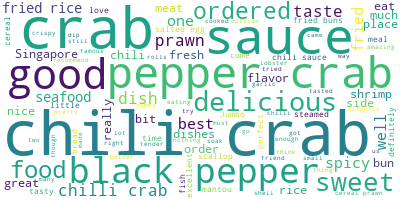

In [289]:
# Wordcloud for taste

# Creating a WordCloud to analyse the data
long_string = ','.join(list(taste_fil["Review"].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

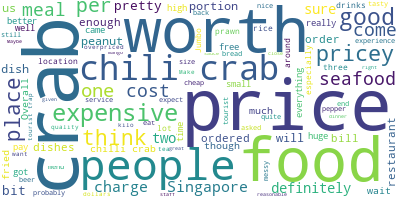

In [290]:
# Wordcloud for price

# Creating a WordCloud to analyse the data
long_string = ','.join(list(value_fil["Review"].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

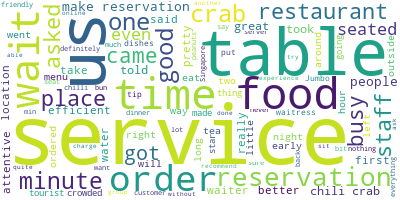

In [291]:
# Wordcloud for service

# Creating a WordCloud to analyse the data
long_string = ','.join(list(service_fil["Review"].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

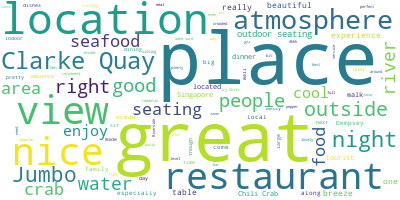

In [292]:
# Wordcloud for ambience

# Creating a WordCloud to analyse the data
long_string = ','.join(list(ambience_fil["Review"].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()